In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import t
from numba import jit
from scipy.linalg import svd

In [ ]:
# DNS factor loading matrix
@jit(nopython=True)
def NS_B(lambda_, tau):
    col1 = np.ones(len(tau))
    col2 = (1 - np.exp(-lambda_ * tau)) / (lambda_ * tau)
    col3 = col2 - np.exp(-lambda_ * tau)
    return np.column_stack((col1, col2, col3))

In [ ]:
# parameter restrictions
def trans(b0):
    b1 = b0.copy()
    b1[:3] = np.log(1 + np.exp(b0[:3]))  # modified line
    b1[6:9] = b0[6:9] ** 2
    b1[9] = b0[9] ** 2
    b1[10:] = b0[10:] ** 2
    return b1

In [ ]:
# inverse transformation of parameters
def inv_trans(b0):
    b1 = b0.copy()
    b1[:3] = np.log(np.exp(b0[:3]) - 1)  # modified line
    b1[6:9] = np.sqrt(b0[6:9])
    b1[9] = np.sqrt(b0[9])
    b1[10:] = np.sqrt(b0[10:])
    return b1

In [ ]:
# negative log likelihood function to be minimized
def loglike(para_un, m_spot):
    para_con = trans(para_un)  # parameter restrictions

    A = np.diag(para_con[:3])         # AR matrix
    MU = para_con[3:6]                # mean vector
    Q = np.diag(para_con[6:9])        # cov in state eq.
    lambda_ = para_con[9]             # lambda
    H = np.diag(para_con[10:])        # cov in measurement eq.

    # factor loading matrix
    B = NS_B(lambda_, v_mat)
    tB = B.T

    # initialization
    prevX = MU
    U, s, VT = svd(np.eye(gnk) - A @ A.T)
    prevV = VT.T @ np.diag(1 / s) @ VT  # modified line
    Phi0 = (np.eye(gnk) - A) @ MU
    Phi1 = A
    loglike_val = 0

    for t in range(nobs):
        # prediction
        Xhat = Phi0 + Phi1 @ prevX
        Vhat = Phi1 @ prevV @ Phi1.T + Q

        # measurement error
        y_real = m_spot[t, :]  # measurement of y
        y_fit = B @ Xhat       # prediction of y
        v = y_real - y_fit     # error

        # updating
        ev = B @ Vhat @ B.T + np.diag(para_con[10:10+nmat])
        evinv = np.linalg.pinv(ev)  # modified line
        KG = Vhat @ tB @ evinv  # Kalman Gain

        prevX = Xhat + KG @ v         # E[X|y_t]   updated mean
        prevV = Vhat - KG @ B @ Vhat  # Cov[X|y_t] updated cov

        # log likelihood function
        loglike_val -= 0.5 * (nmat * np.log(2 * np.pi) + np.log(np.linalg.det(ev)) + v.T @ evinv @ v)  # modified line

        gm_factor[t, :] = prevX

    return -loglike_val

In [ ]:
# Main: DNS term structure model estimation
gnk = 3

# read csv spot data
data = pd.read_csv('/content/drive/MyDrive/Ang and Piazzesi (2003)_v5.1.csv', index_col=0, parse_dates=True)
spot_rates = data[['govt12m', 'govt36m', 'govt60m', 'govt120m']].values

# divide date and data
v_mat = np.array([12, 36, 60, 120])
m_spot = spot_rates
nmat = len(v_mat)  # # of maturities
nobs = m_spot.shape[0]  # # of observations

# factor estimates
gm_factor = np.zeros((nobs, gnk))

In [ ]:
# initial guess for unconstrained parameters(para_un)
init_para_con = np.array([
    9.673486e-01, 9.011626e-01, 7.891438e-01,  # factor AR(1) coefficient
    3.315541e-02, -1.089514e-02, -6.660581e-03,  # unconditional factor mean
    3.194870e-06, 3.202131e-06, 1.105737e-05,  # factor variance
    4.375971e-01,  # lambda
    3.344444e-07, 1.030344e-07, 5.787589e-12, 2.783731e-08,
    9.018871e-08, 5.191208e-08, 4.779619e-08, 1.501038e-07,
    4.134415e-08, 7.313451e-08, 5.929881e-08, 7.771536e-08,
    7.063936e-07  # measurement error variance
])
npara = len(init_para_con)

init_para_un = inv_trans(init_para_con)

m = minimize(loglike, init_para_un, args=(m_spot,), method='L-BFGS-B', options={'maxiter': 5000, 'disp': True})


prev_likev = m.fun
v_likev = [m.fun]

i = 1
while True:
    print(f"{i}-th iteration")
    m = minimize(loglike, m.x, args=(m_spot,), method='L-BFGS-B', options={'maxiter': 5000, 'disp': True})

    v_likev.append(m.fun)
    print(f"{m.fun} <- likelihood value")

    if abs(m.fun - prev_likev) < 1e-11:
        break

    prev_likev = m.fun
    i += 1

    print(v_likev)

name_theta = [
    "a_1", "a_2", "a_3",
    "mu_1", "mu_2", "mu_3",
    "sigma_1", "sigma_2", "sigma_3",
    "lambda", "epsilon_1",
    "epsilon_2", "epsilon_3", "epsilon_4",
    "epsilon_5", "epsilon_6", "epsilon_7",
    "epsilon_8", "epsilon_9", "epsilon_10",
    "epsilon_11", "epsilon_12", "epsilon_13"
]

1-th iteration
-1450.5540459604454 <- likelihood value
[-1450.5540452467706, -1450.5540459604454]
2-th iteration
-1450.554046698164 <- likelihood value
[-1450.5540452467706, -1450.5540459604454, -1450.554046698164]
3-th iteration
-1450.554047019715 <- likelihood value
[-1450.5540452467706, -1450.5540459604454, -1450.554046698164, -1450.554047019715]
4-th iteration
-1450.554047476802 <- likelihood value
[-1450.5540452467706, -1450.5540459604454, -1450.554046698164, -1450.554047019715, -1450.554047476802]
5-th iteration
-1450.5540478706432 <- likelihood value
[-1450.5540452467706, -1450.5540459604454, -1450.554046698164, -1450.554047019715, -1450.554047476802, -1450.5540478706432]
6-th iteration
-1450.5540481975108 <- likelihood value
[-1450.5540452467706, -1450.5540459604454, -1450.554046698164, -1450.554047019715, -1450.554047476802, -1450.5540478706432, -1450.5540481975108]
7-th iteration
-1450.5540484280937 <- likelihood value
[-1450.5540452467706, -1450.5540459604454, -1450.55404669

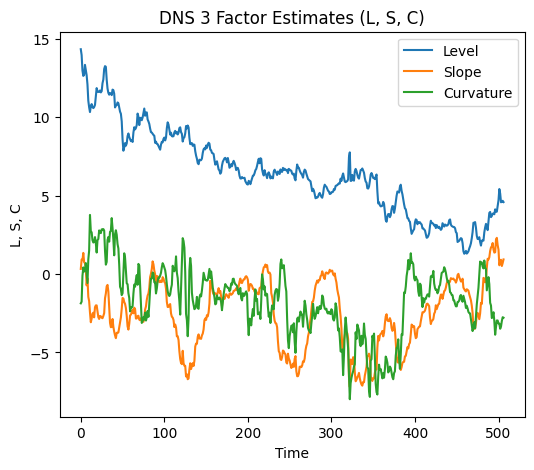

In [ ]:
# draw 3 factor estimates
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 5))
plt.plot(gm_factor)
plt.xlabel('Time')
plt.ylabel('L, S, C')
plt.title('DNS 3 Factor Estimates (L, S, C)')
plt.legend(['Level', 'Slope', 'Curvature'])
plt.show()

In [ ]:
# Delta method for statistical inference
def jacobian(f, x, epsilon=1e-8):
    n = len(x)
    J = np.zeros((n, n))
    for i in range(n):
        h = np.zeros(n)
        h[i] = epsilon
        J[:, i] = (f(x + h) - f(x - h)) / (2 * epsilon)
    return J

def hessian(f, x, epsilon=1e-5):
    n = len(x)
    H = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            h_i = np.zeros(n)
            h_i[i] = epsilon
            h_j = np.zeros(n)
            h_j[j] = epsilon
            H[i, j] = (f(x + h_i + h_j) - f(x + h_i - h_j) - f(x - h_i + h_j) + f(x - h_i - h_j)) / (4 * epsilon ** 2)
            H[j, i] = H[i, j]
    return H

grad = jacobian(trans, m.x)
hess = hessian(lambda x: loglike(x, m_spot), m.x)
vcv_con = grad @ np.linalg.pinv(hess) @ grad.T

In [ ]:
# parameter | std.err | t-value | p-value
theta = trans(m.x)
stderr = np.sqrt(np.diag(vcv_con))
tstat = theta / stderr
pvalue = 2 * t.sf(np.abs(tstat), df=nobs - npara)
df_est = np.column_stack((theta, np.round(stderr, 4), np.round(tstat, 4), np.round(pvalue, 4)))

df_est = pd.DataFrame(df_est, columns=['parameter', 'std.err', 't-stat', 'p-value'], index=name_theta)
print(df_est)

               parameter  std.err    t-stat  p-value
a_1         9.872983e-01   0.0044  223.9252   0.0000
a_2         9.836678e-01   0.0074  132.3596   0.0000
a_3         9.542477e-01   0.0130   73.6340   0.0000
mu_1        5.165976e+00   1.0661    4.8457   0.0000
mu_2       -2.340542e+00   1.0143   -2.3075   0.0214
mu_3       -1.744126e+00   0.6139   -2.8412   0.0047
sigma_1     7.812624e-02   0.0057   13.6111   0.0000
sigma_2     1.464530e-01   0.0092   15.8458   0.0000
sigma_3     4.135148e-01   0.0332   12.4388   0.0000
lambda      3.441998e-02   0.0006   54.1230   0.0000
epsilon_1   3.560661e-02   0.0023   15.6023   0.0000
epsilon_2   2.574983e-17   0.0000    0.0000   1.0000
epsilon_3   3.449926e-17   0.0000    0.0000   1.0000
epsilon_4   2.520281e-04   0.0001    2.1531   0.0318
epsilon_5   9.018871e-08   0.0000       inf   0.0000
epsilon_6   5.191208e-08   0.0000       inf   0.0000
epsilon_7   4.779619e-08   0.0000       inf   0.0000
epsilon_8   1.501038e-07   0.0000       inf   

<ipython-input-11-0d427494766f>:4: RuntimeWarning: divide by zero encountered in divide
  tstat = theta / stderr


In [ ]:
pip install pandas openpyxl

In [ ]:
# gm_factor 데이터를 DataFrame으로 변환 (컬럼은 Level, Slope, Curvature로 지정)
df = pd.DataFrame(gm_factor, columns=['Level', 'Slope', 'Curvature'])

# 엑셀 파일로 내보내기
df.to_excel('dns_factor_estimates.xlsx', index=False)

In [ ]:
# 데이터 준비
data = {
    'Parameter': ['a_1', 'a_2', 'a_3', 'mu_1', 'mu_2', 'mu_3', 'sigma_1', 'sigma_2', 'sigma_3', 'lambda'],
    'Std.Err': [0.0044, 0.0074, 0.0130, 1.0661, 1.0143, 0.6139, 0.0057, 0.0092, 0.0332, 0.0006],
    'T-Stat': [223.9252, 132.3596, 73.6340, 4.8457, -2.3075, -2.8412, 13.6111, 15.8458, 12.4388, 54.1230],
    'P-Value': [0.0000, 0.0000, 0.0000, 0.0000, 0.0214, 0.0047, 0.0000, 0.0000, 0.0000, 0.0000]
}

# 데이터프레임 생성
df = pd.DataFrame(data)

# 엑셀 파일로 저장
output_path = 'dns_factor_estimates.xlsx'
df.to_excel(output_path, index=False)

In [ ]:
from google.colab import files

files.download('dns_factor_estimates.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>